In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import math
import os
import datetime
import re
import math
#from google.colab import drive
from random import sample, seed
import seaborn as sns
import matplotlib.pyplot as plt
#drive.mount('/content/drive')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
import scipy.stats as stats
from tqdm import tqdm

# Data prep

In [2]:
freqs = pd.read_csv('./data/frequenciesExtra.csv')

C:\Users\Christopher\AppData\Local\Temp\ipykernel_1488\512631826.py:1: DtypeWarning: Columns (481) have mixed types. Specify dtype option on import or set low_memory=False.
  freqs = pd.read_csv('./data/frequenciesExtra.csv')


In [3]:
numberRe = re.compile('[0-9]+')
noneRe = re.compile('None')
def daysStrToInt(dStr):
    if isinstance(dStr, str):
        if numberRe.match(dStr):
            return int(dStr.split(' ')[0])
        elif noneRe.match(dStr):
            return None
    return dStr

freqs['hospDistance'] = freqs['hospDistance'].transform(daysStrToInt)

In [4]:
def deIdCrf(crfs):
  return crfs.drop(columns=['Masked Client ID', 'Date of Review', 'Date'])

def deIdAdl(adls):
  return adls.drop(columns=['DeIdentify ID', 'CaregiverID', 'VisitDate', 'ActualTimeIn', 'ActualTimeOut', 'Date'])

In [5]:
# Create columns for fitting
full_x = freqs.drop(columns=['hasHospitalization', 'hospDistance'])
#x = deIdAdl(freqs).drop(columns=['hasHospitalization', 'hospDistance'])
x = deIdAdl(full_x)
y = freqs['hasHospitalization']
d = freqs['hospDistance']

In [6]:
# Prep data for ridge regression
d_notnull = d.loc[d.transform(lambda x: not np.isnan(x))]

In [7]:
# Bad way of executing this algorithm for a smaller amount of cat_labels or a larger amount of y_labels or an overzealous diff
# Currently random bruteforce therefore unknown execution time
def generate_split_mask(categories, y, test_ratio, **kwargs):
    # Pull kwargs
    rand_seed_base = kwargs['seed'] if 'seed' in kwargs else 0
    split_diff = kwargs['split_diff'] if 'split_diff' in kwargs else 1
    class_diff = kwargs['class_diff'] if 'class_diff' in kwargs else 1

    # Make category label set
    cat_labels = [v for v in set(categories)]

    rand_seed = rand_seed_base
    split_error = 2
    max_class_error = 2
    while abs(split_error) > split_diff or abs(max_class_error) > class_diff:
        # Select random seed and choose `test_ratio` cats from `cat_labels`
        seed(rand_seed)
        if rand_seed%50 == 0:
            print(rand_seed)
        rand_seed += 1
        sub = sample(cat_labels, math.ceil(len(cat_labels)*test_ratio))

        # Make masks based off `sub`
        test_mask = [v in sub for v in categories]
        train_mask = [not v for v in test_mask]

        # Get `split_error` and continue if not met
        split_error = sum(test_mask)/len(categories) - test_ratio
        if abs(split_error) - test_ratio > split_diff:
            continue

        # Make result label set
        y_labels = [v for v in set(y)]
        y_labels_map = {y_labels[v]:v for v in range(0,len(y_labels))}

        # Populate result train/test
        y_train_count = [0 for _ in y_labels]
        y_test_count = [0 for _ in y_labels]
        for i in range(0,len(y)):
            v = y[i]
            if test_mask[i]:
                y_test_count[y_labels_map[v]] += 1
            else:
                y_train_count[y_labels_map[v]] += 1

        # Get `class_error` and continue if not met
        class_error = [None for _ in y_labels]
        for i in range(0,len(y_labels)):
            class_error[i] = y_test_count[i]/(y_train_count[i] + y_test_count[i]) - test_ratio
        max_class_error = max([abs(v) for v in class_error])
    print(f'Split generated with seed {rand_seed - 1}\nSplit error: {split_error}\nClass error: {class_error}')
    return train_mask, test_mask

def apply_split_mask(data, mask):
    t_vals = []
    f_vals = []
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        t_vals = data.loc[mask]
        f_vals = data.loc[[not v for v in mask]]
    else:
        for i in range(0,len(mask)):
            v = data[i]
            if mask[i]:
                t_vals.append(v)
            else:
                f_vals.append(v)
    return t_vals, f_vals


In [8]:
# Train test split over Clients instead of random
train_mask, test_mask = generate_split_mask(full_x['DeIdentify ID'], y, .25, seed=157, split_diff=.005, class_diff=.005)
d_notnull_index = np.intersect1d(d_notnull.index, [i for i in range(0,len(test_mask)) if test_mask[i] is True])
d_test_mask = [v in d_notnull_index for v in range(0,len(d))]
d_train_mask = [not v for v in d_test_mask]

full_x_train, full_x_test = apply_split_mask(full_x, train_mask)
y_train, y_test = apply_split_mask(y, train_mask)
x_train, x_test = apply_split_mask(deIdAdl(full_x), train_mask)

counts = np.array([list(y_train.value_counts()), list(y_test.value_counts())])
counts_scaled = np.array([[v/sum(counts[:,i]) for v in counts[:,i]] for i in range(y.nunique())]).transpose()
print(f'Train size: {sum(train_mask)} Test size: {sum(test_mask)}\nTrain ratio:\n{counts_scaled[0]}\nTest ratio:\n{counts_scaled[1]}')

200
Split generated with seed 230
Split error: -0.004349575324094773
Class error: [-0.004366733755031632, -0.0009025270758122872]
Train size: 42187 Test size: 13738
Train ratio:
[0.75436673 0.75090253]
Test ratio:
[0.24563327 0.24909747]


In [9]:
# Prepare for two part solution

d_notnull_index = np.intersect1d(d_notnull.index, [i for i in range(0,len(test_mask)) if test_mask[i] is True])
d_test_mask = [v in d_notnull_index for v in range(0,len(d))]
d_train_mask = [not v for v in d_test_mask]

twostep_mask = d.transform(lambda x: not np.isnan(x))
d_notnull_x = x.loc[twostep_mask]
d_notnull_y = y.loc[twostep_mask]
d_x_train = x.iloc[d_train_mask]
d_y_train = d.iloc[d_train_mask]
d_x_test = x.iloc[d_test_mask]
d_y_test = d.iloc[d_test_mask]
twostep_train = twostep_mask.iloc[y_train.index]
twostep_test = twostep_mask.iloc[y_test.index]

In [ ]:
# Binning is out in favor of a regression
"""
#Perform binning
bins = [{'n': '0-50', 'r': range(0,50)}, {'n': '50-100', 'r': range(50,100)}, {'n': '100-200', 'r': range(100,200)}]
b = []
for v in d:
    i = 0
    while i < len(bins):
        if v in bins[i]['r']:
            break
        i += 1
    b.append(i)
b = list(map(lambda x: bins[x]['n'] if x < len(bins) else '200+', b))
"""

"\n#Perform binning\nbins = [{'n': '0-50', 'r': range(0,50)}, {'n': '50-100', 'r': range(50,100)}, {'n': '100-200', 'r': range(100,200)}]\nb = []\nfor v in d:\n    i = 0\n    while i < len(bins):\n        if v in bins[i]['r']:\n            break\n        i += 1\n    b.append(i)\nb = list(map(lambda x: bins[x]['n'] if x < len(bins) else '200+', b))\n"

In [ ]:
"""
a = pd.Series(data=b)
y_train = a.loc[train_mask]
y_test = a.loc[test_mask]
"""

'\na = pd.Series(data=b)\ny_train = a.loc[train_mask]\ny_test = a.loc[test_mask]\n'

In [15]:
# Out in favor of proprietary train test split above
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(x, b, test_size=.25, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(full_x, y, test_size=.25, random_state=15)
#x_train, x_test, twostep_train, twostep_test = train_test_split(x, twostep_mask, test_size=.25, random_state=15)

In [ ]:
#New column in frequency data
#Has been to hospital before / of all CRFs how many times was hospitalization

In [10]:
def transformData(method, x_train, x_test):
    # Return retObjs as well as to transform future entries
    retObjs = {}
    if 'pca' in method:
        PCA_O = PCA(n_components=200)
        pca_train = PCA_O.fit_transform(x_train)
        pca_test = PCA_O.transform(x_test)
        retObjs['pca'] = PCA_O
        using_train = pca_train
        using_test = pca_test
    elif 'raw' in method:
        using_train = x_train
        using_test = x_test
    else:
        print(f'Data format \'{method}\' not defined')
        return None, None, None

    if 'scale' in method:
        scaler = StandardScaler()
        scale_train = scaler.fit_transform(using_train)
        scale_test = scaler.transform(using_test)
        retObjs['scale'] = scaler
        using_train = scale_train
        using_test = scale_test
    
    return using_train, using_test, retObjs

In [11]:
using_train, using_test, _ = transformData('raw scaled', x_train, x_test)
#using_train, using_test, _ = transformData('raw', x_train, x_test)

# Grid search

In [149]:
doGridSearch = True

In [151]:
if doGridSearch:
    """
    searchParams = {
        'kernel': ['linear', 'poly', 'sigmoid'],
        'C': [.1, .5, 1, 5, 10],
        'class_weight': [
            'balanced',
            {'0-50': 20, '50-100': 10, '100-200': 5, '200+': 1},
            {'0-50': 1, '50-100': 5, '100-200': 10, '200+': 20},
            {'0-50': 10, '50-100': 1, '100-200': 1, '200+': 10},
            {'0-50': 1, '50-100': 10, '100-200': 10, '200+': 1},
            {'0-50': 10, '50-100': 10, '100-200': 1, '200+': 1},
            {'0-50': 10, '50-100': 5, '100-200': 1, '200+': 1}
        ]
    }
    """

    """
    possibleWeights = [1, 5, 10, 20]
    #possibleWeights = [{0.0: i, 1.0: j} for i in possibleWeights for j in possibleWeights]
    possibleWeights = [{False: i, True: j} for i in possibleWeights for j in possibleWeights]
    possibleWeights.append('balanced')

    print(f'Possible weights: {possibleWeights}\n')
    """

    """
    searchParamsA = {
        'kernel': ['linear', 'sigmoid'],
        'C': [.1, .5, 1, 5, 10],
        'class_weight': possibleWeights
    }

    searchParamsB = {
        'kernel': ['poly'],
        'degree': [2, 3, 4],
        'C': [.1, .5, 1, 5, 10],
        'class_weight': possibleWeights
    }
    """

    possibleWeights = [100, 150, 200, 250, 300, 350, 400]
    possibleWeights = [{False: i, True: 1} for i in possibleWeights]

    searchParams = {
        'kernel': ['linear'],
        'C': [.01, .05, .1, .5, 1],
        'class_weight': possibleWeights
    }

    #searchParams = [searchParamsA, searchParamsB]
    print(f'All params: {searchParams}\n')

    grid_models = GridSearchCV(estimator=SVC(), param_grid=searchParams, n_jobs=-3, verbose=2)

    grid_models.fit(using_train, y_train)

All params: {'kernel': ['linear'], 'C': [0.01, 0.05, 0.1, 0.5, 1], 'class_weight': [{False: 100, True: 1}, {False: 150, True: 1}, {False: 200, True: 1}, {False: 250, True: 1}, {False: 300, True: 1}, {False: 350, True: 1}, {False: 400, True: 1}]}

Fitting 5 folds for each of 35 candidates, totalling 175 fits


In [ ]:
if doGridSearch:
    [grid_models.cv_results_['params'][v] for v in [1, 9, 17, 25, 170, 182, 194, 206]]
    #a = pd.Series(data=grid_models.cv_results_['rank_test_score'])
    #a.loc[a == 1]
    grid_models.cv_results_['params'][33]

{'C': 0.1, 'class_weight': 'balanced', 'kernel': 'sigmoid'}

In [ ]:
a = pd.Series(data=grid_models.cv_results_['rank_test_score'])
a.loc[a == a.min()]
#181 172
[grid_models.cv_results_['params'][v] for v in [172, 181]]

[{'C': 0.1,
  'class_weight': {False: 1, True: 1},
  'degree': 4,
  'kernel': 'poly'},
 {'C': 0.1,
  'class_weight': {False: 1, True: 20},
  'degree': 4,
  'kernel': 'poly'}]

In [154]:
if doGridSearch:
    pred_train = grid_models.predict(using_train)
    pred_test = grid_models.predict(using_test)
    print(f'Train:\n{classification_report(y_train, pred_train)}')
    print(f'Test:\n{classification_report(y_test, pred_test)}')

Train:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41722
         1.0       1.00      0.59      0.74       221

    accuracy                           1.00     41943
   macro avg       1.00      0.79      0.87     41943
weighted avg       1.00      1.00      1.00     41943

Test:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13926
         1.0       0.82      0.55      0.66        56

    accuracy                           1.00     13982
   macro avg       0.91      0.78      0.83     13982
weighted avg       1.00      1.00      1.00     13982



In [ ]:
if doGridSearch:
    print('CV Search:')
    print(classification_report(twostep_test, pred_test))

CV Search:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      6645
         1.0       0.00      0.00      0.00        33

    accuracy                           0.99      6678
   macro avg       0.50      0.50      0.50      6678
weighted avg       0.99      0.99      0.99      6678



In [ ]:
twostep_train.value_counts()

False    45816
True      3431
Name: hospDistance, dtype: int64

# Fit models

In [12]:
#SVM to classify close or not works well
#Ridge to determine values works well with scaled


#RBF Kernel with larger gamma

#weights = {1.0: 200, 0.0: 1}
#weights = {1.0: 50, 0.0: 1}
#weights = {1.0: 1, 0.0: 200}
#weights = {1.0: 1, 0.0: 50}

#weights = {1.0: 100, 0.0: 1}


#weights = {'0-50': 20, '50-100': 20, '100-200': 5, '200+': 1}
#weights = {'0-50': 1, '50-100': 5, '100-200': 5, '200+': 10}
#weights = {'0-50': 1, '50-100': 5, '100-200': 10, '200+': 20}
#weights = {'0-50': 10, '50-100': 5, '100-200': 1, '200+': 1}
#weights = {'0-50': 10, '50-100': 1, '100-200': 1, '200+': 10}

#Grid best
#Raw binned data 
#model = SVC(kernel='poly', C=0.1, class_weight='balanced')
#Raw oneclass data
#model = SVC(kernel='poly', degree=2, C=0.1, class_weight={1.0: 10, 0.0: 1})
#model = SVC(kernel='sigmoid', C=0.1, class_weight='balanced')

#class_model = SVC(kernel='linear', C=0.1, class_weight={0.0: 200, 1.0: 1})
#class_model = SVC(kernel='linear', C=0.1, class_weight={0.0: 100, 1.0: 1}, probability=True)
#class_model = SVC(kernel='linear', C=10, class_weight={0.0: 100, 1.0: 1}, probability=True)
#class_model = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree',p=2, n_jobs= -3)

class_model = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', verbose=2, n_jobs=4, max_iter=1000)
# L2 regularized model since L2 is shown to be the best on this dataset but is it even ok?
reg_model = Ridge(alpha=100, max_iter=500, solver='saga')

#model = SVC(kernel='poly', C=10, class_weight='balanced')
#model = SVC(kernel='poly', C=1, degree=3, class_weight='balanced')
#model = SVC(kernel='poly', C=1, degree=3)
#model = SVC(kernel='poly', C=1, degree=3, class_weight=weights)
#model = SVC(kernel='linear', C=10, class_weight='balanced', probability=True)
#model = SVC(kernel='linear', C=10, class_weight=weights)
#model = SVC(kernel='linear', C=1, class_weight='balanced')
#model = SVC(kernel='linear', C=1, class_weight=weights)
#model = SVC(kernel='linear', C=0.5, class_weight=weights)
#model = SVC(kernel='linear')
#model = DecisionTreeClassifier(criterion='entropy')
#model = KNeighborsClassifier(n_neighbors=5)
#model = BaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10, random_state=15)

class_model.fit(using_train, twostep_train)
#class_model.fit(using_train, twostep_train)
reg_model.fit(d_notnull_x, d_notnull)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.7s finished


# Graphical analysis of new models

In [13]:
tryNewModels = True

In [ ]:
if tryNewModels:
    #Ridge Comparison
    def calculateScores(conf):
        precision = conf[1,1]/sum(conf[:,1])
        recall = conf[1,1]/sum(conf[1])
        f1Score = 2/(1/precision + 1/recall)
        return precision, recall, f1Score

    cols = ['Alpha', 'R2']
    train_scores = pd.DataFrame(columns=cols)
    test_scores = pd.DataFrame(columns=cols)
    comb_scores = pd.DataFrame(columns=cols)
    test_error = pd.DataFrame(columns=cols)
    allscores = []

    for i in tqdm(range(1,1001)):
        model = Lasso(alpha=i)
        model.fit(d_x_train, d_y_train)
        #pred_train = model.predict(using_train)
        pred_test = model.predict(d_x_test)
        allscores.append(pred_test)

        #train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[i, r2_score(y_train, pred_train)]).to_frame().T], ignore_index=True)
        #test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[i, r2_score(y_test, pred_test)]).to_frame().T], ignore_index=True)
        s_train = model.score(d_x_train, d_y_train)
        s_test = model.score(d_x_test, d_y_test)
        train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[i, s_train]).to_frame().T], ignore_index=True)
        test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[i, s_test]).to_frame().T], ignore_index=True)
        comb_scores = pd.concat([comb_scores, pd.Series(index=cols, data=[i, (s_test*(1-s_train))]).to_frame().T], ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Christopher\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+06, tolerance: 3.727e+03
  model = cd_fast.enet_coordinate_descent(
  0%|          | 1/1000 [00:00<11:34,  1.44it/s]c:\Users\Christopher\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e+06, tolerance: 3.727e+03
  model = cd_fast.enet_coordinate_descent(
  0%|          | 2/1000 [00:01<10:32,  1.58it/s]c:\Users\Christopher\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\l

In [ ]:
if tryNewModels:
    #Elastic net comparison
    def calculateScores(conf):
        precision = conf[1,1]/sum(conf[:,1])
        recall = conf[1,1]/sum(conf[1])
        f1Score = 2/(1/precision + 1/recall)
        return precision, recall, f1Score

    cols = ['Ratio', 'Alpha', 'R2']
    train_scores = pd.DataFrame(columns=cols)
    test_scores = pd.DataFrame(columns=cols)
    comb_scores = pd.DataFrame(columns=cols)
    test_error = pd.DataFrame(columns=cols)
    allscores = []

    step = .01
    for j in tqdm(range(1,1000+1,10)):
        #rat = step*i
        rat = 0
        #model = ElasticNet(l1_ratio=rat, alpha=j)
        reg_model = Ridge(alpha=j, max_iter=10000)
        model.fit(d_x_train, d_y_train)
        #pred_train = model.predict(using_train)
        pred_test = model.predict(d_x_test)
        allscores.append(pred_test)

        #train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[i, r2_score(y_train, pred_train)]).to_frame().T], ignore_index=True)
        #test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[i, r2_score(y_test, pred_test)]).to_frame().T], ignore_index=True)
        s_train = model.score(d_x_train, d_y_train)
        s_test = model.score(d_x_test, d_y_test)
        train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[rat, j, s_train]).to_frame().T], ignore_index=True)
        test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[rat, j, s_test]).to_frame().T], ignore_index=True)
        comb_scores = pd.concat([comb_scores, pd.Series(index=cols, data=[rat, j, (s_test*(1-s_train))]).to_frame().T], ignore_index=True)

100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


Index(['Ratio', 'Alpha', 'R2'], dtype='object')


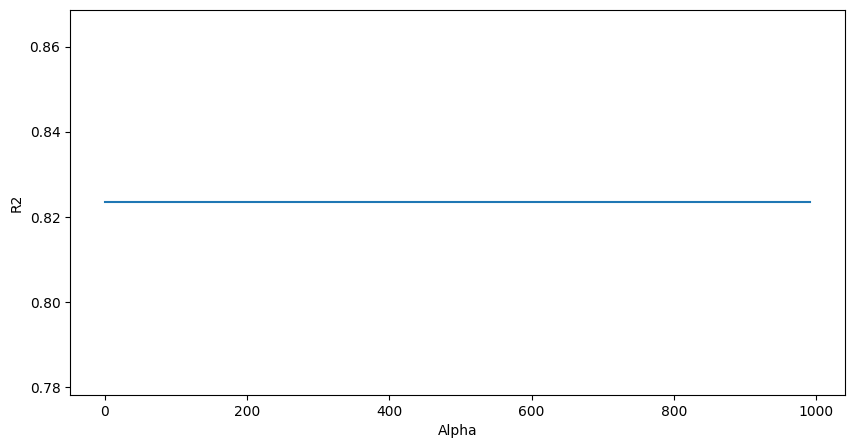

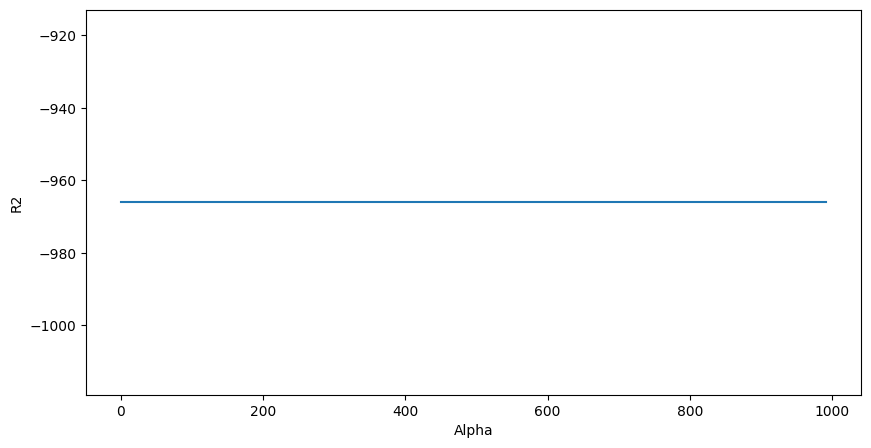

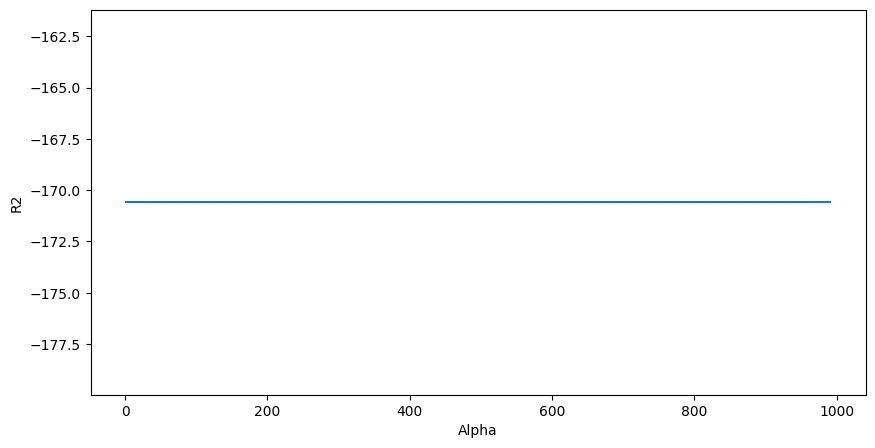

In [ ]:
if tryNewModels:
    print(train_scores.columns)
    plt.figure(figsize=(10,5))
    sns.lineplot(y='R2', x='Alpha', data=train_scores.loc[train_scores['Ratio'] == 0])
    plt.figure(figsize=(10,5))
    sns.lineplot(y='R2', x='Alpha', data=test_scores.loc[test_scores['Ratio'] == 0])
    plt.figure(figsize=(10,5))
    sns.lineplot(y='R2', x='Alpha', data=comb_scores.loc[comb_scores['Ratio'] == 0])

In [ ]:
pred_train = model.predict(d_x_train)
pred_test = model.predict(d_x_test)

#len(pred_test[0])
print(f'Train: {r2_score(d_y_train, pred_train)} Test: {r2_score(d_y_test, pred_test)}')

Train: 0.7892190614695568 Test: -369.42694399412426


In [14]:
# Logistic regression

if tryNewModels:
    def calculateScores(conf):
        precision = conf[1,1]/sum(conf[:,1])
        recall = conf[1,1]/sum(conf[1])
        f1Score = 2/(1/precision + 1/recall)
        return precision, recall, f1Score
    
    #Logistic regression (Softmax)
    model = LogisticRegression(C=1, penalty='l2', verbose=2, n_jobs=-3, max_iter=10000)
    model.fit(using_train, twostep_train)
    pred_train = model.predict(using_train)
    pred_test = model.predict(using_test)

    cols = ['Regularization', 'Precision', 'Recall', 'F1']
    train_scores = pd.DataFrame(columns=cols)
    test_scores = pd.DataFrame(columns=cols)
    allscores = []

    for i in tqdm(range(1,100+1)):
        v = i/100
        model = LogisticRegression(C=v, penalty='l2', verbose=2, n_jobs=-2, max_iter=1000, class_weight='balanced')
        model.fit(using_train, twostep_train)
        pred_train = model.predict(using_train)
        pred_test = model.predict(using_test)
        allscores.append(pred_test)
        conf_train = confusion_matrix(y_true=twostep_train, y_pred=pred_train)
        conf_test = confusion_matrix(y_true=twostep_test, y_pred=pred_test)

        #Looking for high recall
        p, r, f = calculateScores(conf_train)
        train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[v, p, r, f]).to_frame().T], ignore_index=True)
        p, r, f = calculateScores(conf_test)
        test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[v, p, r, f]).to_frame().T], ignore_index=True)
        #test_scores = test_scores.append(pd.Series(index=cols, data=[i, p, r, f]), ignore_index=True)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:   19.2s finished
  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    8.9s finished
  1%|          | 1/100 [00:09<15:34,  9.44s/it][Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   11.3s finished
  2%|▏         | 2/100 [00:21<17:46, 10.88s/it][Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   10.9s finished
  3%|▎         | 3/100 [00:32<18:03, 11.17s/it][Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   12.0s finished
  4%|▍         | 4/100 [00:45<18:43, 11.70s/it][Parallel(n_jobs=-2)]: Using back

In [ ]:
if tryNewModels:
    #KNN Comparison
    def calculateScores(conf):
        precision = conf[1,1]/sum(conf[:,1])
        recall = conf[1,1]/sum(conf[1])
        f1Score = 2/(1/precision + 1/recall)
        return precision, recall, f1Score

    cols = ['Neighbors', 'Precision', 'Recall', 'F1']
    train_scores = pd.DataFrame(columns=cols)
    test_scores = pd.DataFrame(columns=cols)
    allscores = []

    for i in tqdm(range(1,51)):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(using_train, twostep_train)
        pred_train = model.predict(using_train)
        pred_test = model.predict(using_test)
        allscores.append(pred_test)
        conf_train = confusion_matrix(y_true=twostep_train, y_pred=pred_train)
        conf_test = confusion_matrix(y_true=twostep_test, y_pred=pred_test)

        #Looking for high recall
        p, r, f = calculateScores(conf_train)
        train_scores = pd.concat([train_scores, pd.Series(index=cols, data=[i, p, r, f]).to_frame().T], ignore_index=True)
        p, r, f = calculateScores(conf_test)
        test_scores = pd.concat([test_scores, pd.Series(index=cols, data=[i, p, r, f]).to_frame().T], ignore_index=True)
        #test_scores = test_scores.append(pd.Series(index=cols, data=[i, p, r, f]), ignore_index=True)

 82%|████████▏ | 41/50 [11:19<02:27, 16.44s/it]C:\Users\Christopher\AppData\Local\Temp\ipykernel_25196\1271142252.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  f1Score = 2/(1/precision + 1/recall)
 84%|████████▍ | 42/50 [11:37<02:14, 16.77s/it]C:\Users\Christopher\AppData\Local\Temp\ipykernel_25196\1271142252.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  f1Score = 2/(1/precision + 1/recall)
 86%|████████▌ | 43/50 [11:54<01:57, 16.81s/it]C:\Users\Christopher\AppData\Local\Temp\ipykernel_25196\1271142252.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  f1Score = 2/(1/precision + 1/recall)
 88%|████████▊ | 44/50 [12:10<01:40, 16.71s/it]C:\Users\Christopher\AppData\Local\Temp\ipykernel_25196\1271142252.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  f1Score = 2/(1/precision + 1/recall)
 90%|█████████ | 45/50 [12:27<01:23, 16.64s/it]C:\Users\Christopher\AppData\Local\Temp\ipykernel_25196\1271142252.py:6: 

Training Results


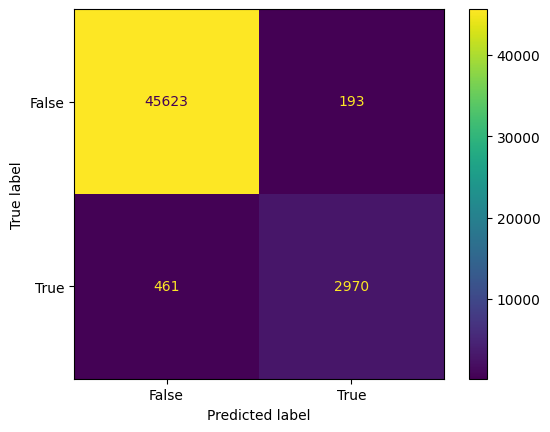

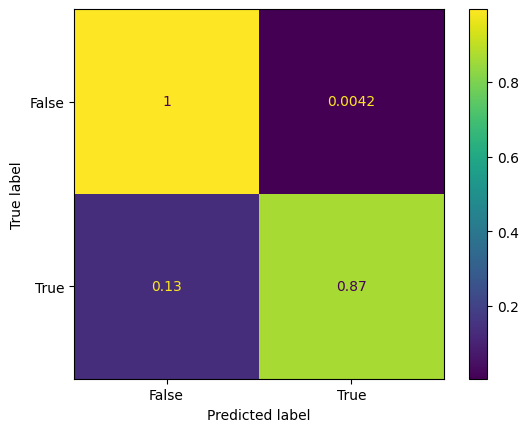

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     45816
        True       0.94      0.87      0.90      3431

    accuracy                           0.99     49247
   macro avg       0.96      0.93      0.95     49247
weighted avg       0.99      0.99      0.99     49247

Testing Results


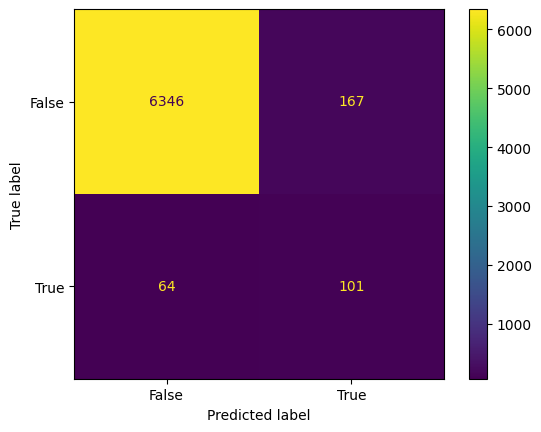

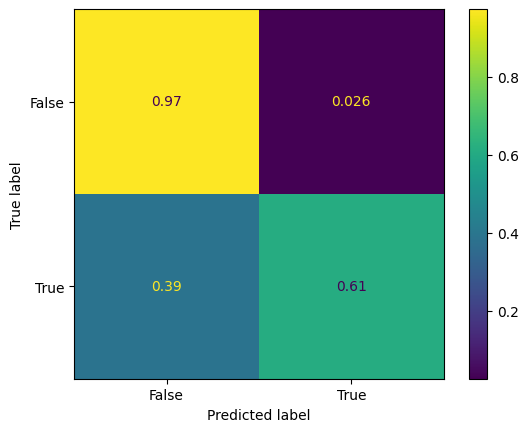

              precision    recall  f1-score   support

       False       0.99      0.97      0.98      6513
        True       0.38      0.61      0.47       165

    accuracy                           0.97      6678
   macro avg       0.68      0.79      0.72      6678
weighted avg       0.97      0.97      0.97      6678



In [ ]:
if tryNewModels:
    #Classification training results
    print('Training Results')
    conf_train = confusion_matrix(y_true=twostep_train, y_pred=pred_train)
    ConfusionMatrixDisplay.from_predictions(y_true=twostep_train, y_pred=pred_train)
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_true=twostep_train, y_pred=pred_train, normalize='true')
    plt.show()
    print(classification_report(twostep_train, pred_train))

    #Classification test results
    print('Testing Results')
    conf_train = confusion_matrix(y_true=twostep_test, y_pred=pred_test)
    ConfusionMatrixDisplay.from_predictions(y_true=twostep_test, y_pred=pred_test)
    plt.show()
    ConfusionMatrixDisplay.from_predictions(y_true=twostep_test, y_pred=pred_test, normalize='true')
    plt.show()
    print(classification_report(twostep_test, pred_test))

In [15]:
if tryNewModels:
    def categorizeIndCols(row):
        ret = []
        for v in ['Precision', 'Recall', 'F1']:
            ret.append({'Regularization': row['Regularization'], 'ScoreType': v, 'Score': row[v]})
        return ret

    def unrollArray(w):
        return [v for t in w for v in t]

    #a = unrollArray(train_scores.apply(lambda r: categorizeIndCols(r), axis=1))
    train_scores_m = pd.DataFrame(data=unrollArray(train_scores.apply(lambda r: categorizeIndCols(r), axis=1)))
    test_scores_m = pd.DataFrame(data=unrollArray(test_scores.apply(lambda r: categorizeIndCols(r), axis=1)))

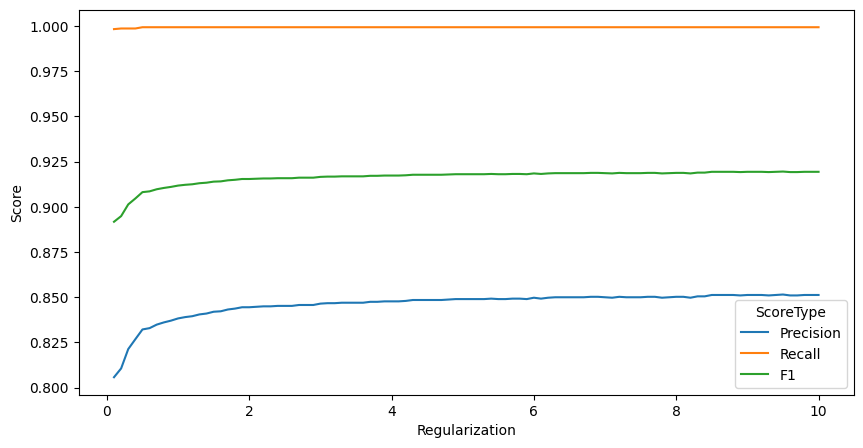

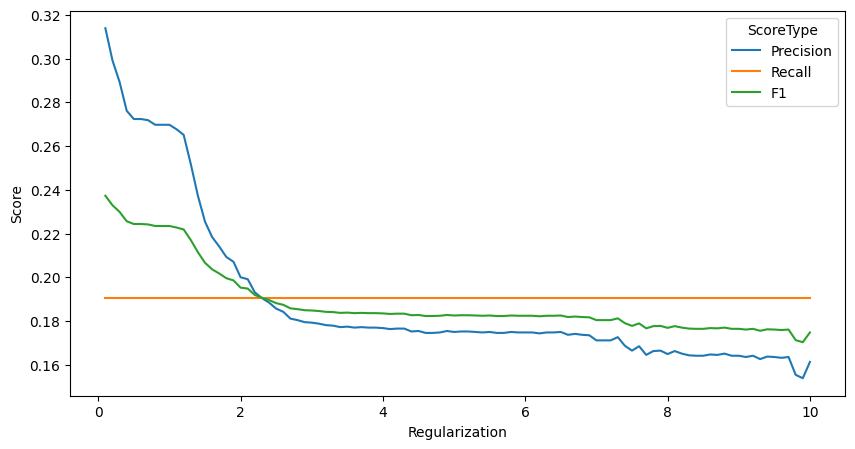

In [16]:
if tryNewModels:
    plt.figure(figsize=(10,5))
    sns.lineplot(y='Score', x='Regularization', hue='ScoreType', data=train_scores_m)
    if len(test_scores_m.loc[test_scores_m['Score'] > 0]) > 0:
        plt.figure(figsize=(10,5))
        sns.lineplot(y='Score', x='Regularization', hue='ScoreType', data=test_scores_m)
    else:
        print('No non-zero test results')

# Categorization error

In [ ]:
y_test.value_counts()

0.0    13926
1.0       56
Name: hasHospitalization, dtype: int64

In [ ]:
class_pred_train = class_model.predict(using_train)
class_pred_test = class_model.predict(using_test)

In [192]:
prob_pred_train = class_model.predict_proba(using_train)
prob_pred_test = class_model.predict_proba(using_test)

In [185]:
len(prob_pred_train)

41943

<AxesSubplot: ylabel='Count'>

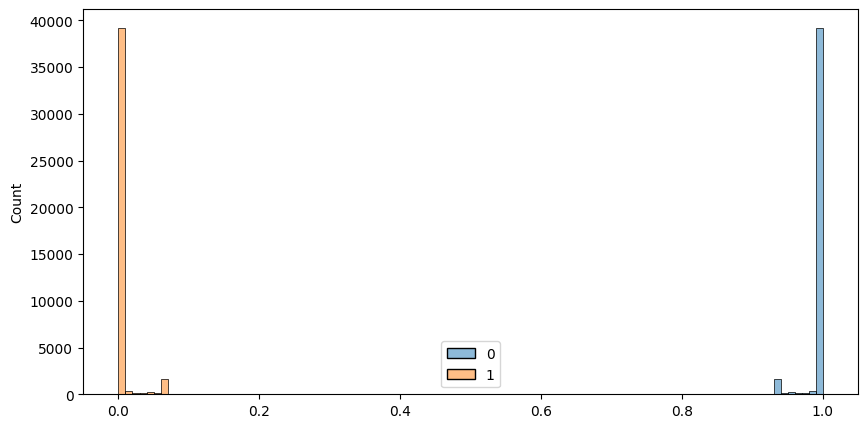

In [193]:
plt.figure(figsize=(10,5))
#plt.xlim(.4, .6)
#plt.ylim(0, 25)
sns.histplot(data=prob_pred_train, bins=100)

In [ ]:
print('Client split class:')
print(classification_report(twostep_test, class_pred_test))

Client split class:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     13149
        True       0.97      0.04      0.07       833

    accuracy                           0.94     13982
   macro avg       0.96      0.52      0.52     13982
weighted avg       0.94      0.94      0.92     13982



In [26]:
print('Regular split class:')
#print(classification_report(twostep_test, class_pred_test))
print(classification_report(y_test, class_pred_test))

Regular split class:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13926
         1.0       0.89      0.55      0.68        56

    accuracy                           1.00     13982
   macro avg       0.94      0.78      0.84     13982
weighted avg       1.00      1.00      1.00     13982



Training Results


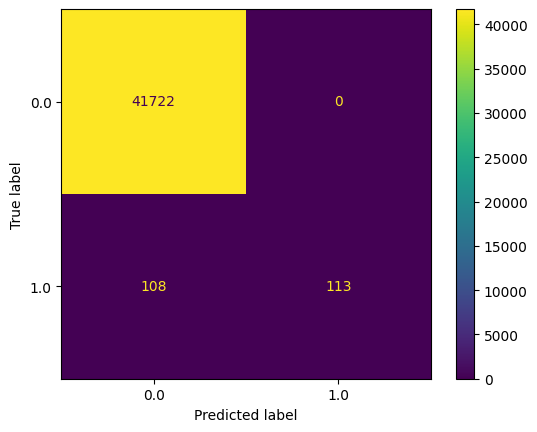

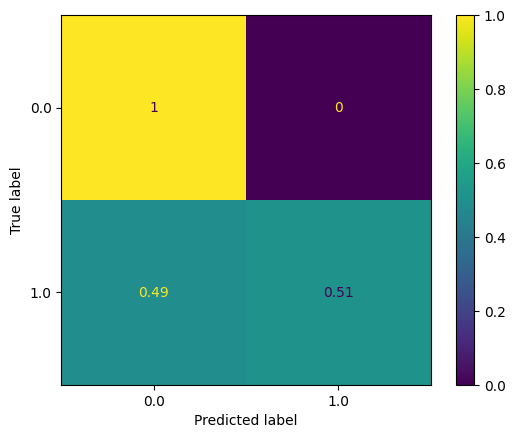

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41722
         1.0       1.00      0.51      0.68       221

    accuracy                           1.00     41943
   macro avg       1.00      0.76      0.84     41943
weighted avg       1.00      1.00      1.00     41943



In [175]:
#Classification training results
print('Training Results')
#true_train = twostep_train
true_train = y_train
conf_train = confusion_matrix(y_true=true_train, y_pred=class_pred_train)
ConfusionMatrixDisplay.from_predictions(y_true=true_train, y_pred=class_pred_train)
plt.show()
ConfusionMatrixDisplay.from_predictions(y_true=true_train, y_pred=class_pred_train, normalize='true')
plt.show()
print(classification_report(true_train, class_pred_train))

Testing Results


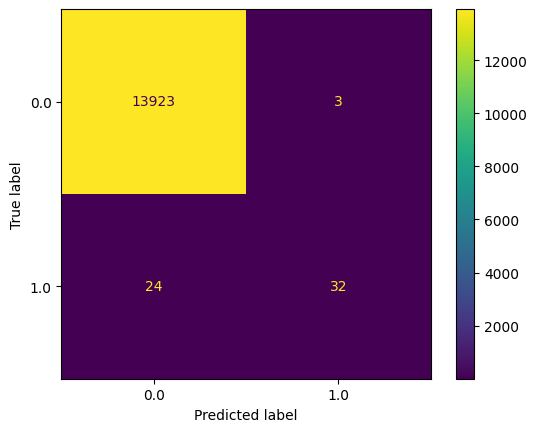

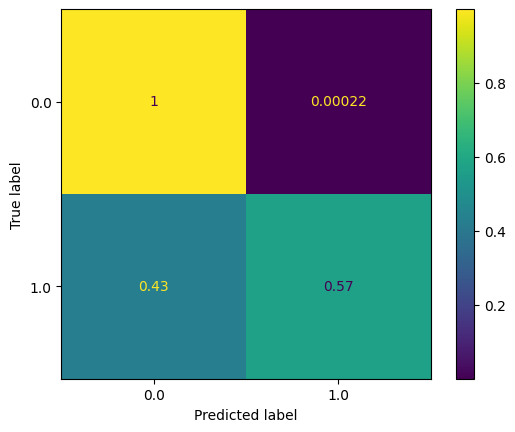

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13926
         1.0       0.91      0.57      0.70        56

    accuracy                           1.00     13982
   macro avg       0.96      0.79      0.85     13982
weighted avg       1.00      1.00      1.00     13982



In [176]:
#Classification test results
print('Testing Results')
#true_test = twostep_test
true_test = y_test
conf_train = confusion_matrix(y_true=true_test, y_pred=class_pred_test)
ConfusionMatrixDisplay.from_predictions(y_true=true_test, y_pred=class_pred_test)
plt.show()
ConfusionMatrixDisplay.from_predictions(y_true=true_test, y_pred=class_pred_test, normalize='true')
plt.show()
print(classification_report(true_test, class_pred_test))

In [ ]:
"""
conf_train = confusion_matrix(y_true=y_train, y_pred=pred_train)
conf_test = confusion_matrix(y_true=y_test, y_pred=pred_test)

def calculateScores(conf):
    precision = conf[1,1]/sum(conf[:,1])
    recall = conf[1,1]/sum(conf[1])
    f1Score = 2/(1/precision + 1/recall)
    return precision, recall, f1Score

#Looking for high recall
print('TRAIN')
p, r, f = calculateScores(conf_train)
w = 3/(1/p + 2/r)
print(f'Precision: {p}\nRecall: {r}\nF1 Score: {f}\nWeighted F1: {w}\n')
print('TEST')
p, r, f = calculateScores(conf_test)
w = 3/(1/p + 2/r)
print(f'Precision: {p}\nRecall: {r}\nF1 Score: {f}\nWeighted F1: {w}')
"""

# Prediction and error

In [ ]:
ridge_pred_train = reg_model.predict(d_notnull_x)
print(f'Regression training error: {r2_score(d_notnull, ridge_pred_train)}')
# Get points classified as close
close_class = x_test.loc[class_pred_test == 1.0]
ridge_pred_test = reg_model.predict(close_class)
# Can't get testing error since don't know true labels
#print(f'Regression testing error: {r2_score(d, ridge_pred_train)}')

Regression training error: 0.8043821369080064


<AxesSubplot:ylabel='Count'>

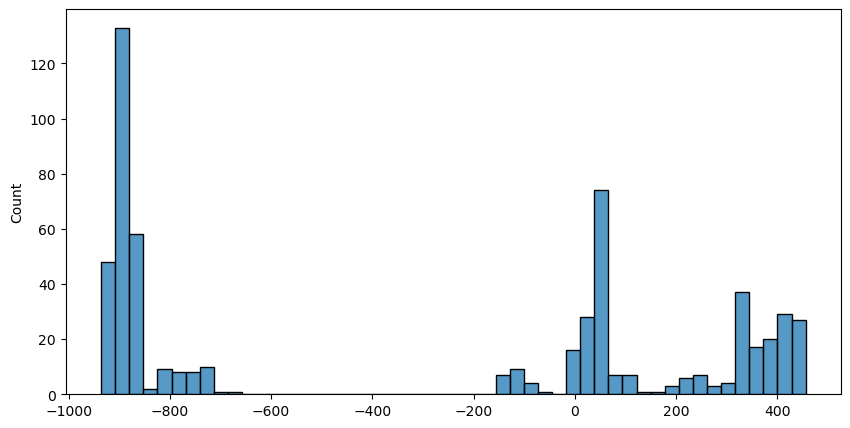

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=ridge_pred_test, bins=50)

In [ ]:
a = pd.Series(data=ridge_pred_test)
print(f'{len(a[a < 0])/len(a)} below 0')

0.5221843003412969 below 0


/Users/chrszlr/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chrszlr/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

# Visualization

In [ ]:
#Only usable for linear kernel
def computeDistance(x_vals, model):
    p = model.decision_function(x_vals)
    w_norm = np.linalg.norm(model.coef_)
    dist = p / w_norm
    dist = p
    return pd.Series(data=dist)

In [ ]:
dist_train = computeDistance(x_train, model)
dist_test = computeDistance(x_test, model)
#CHANGE FOR WHICH SET SHOULD BE COMPUTED
dist = dist_test
graphData = []
step = 20
boundary = min(dist)
rng = max(dist)-boundary
for i in range(0,1+step):
    v = boundary+(i/step)*rng
    # nope # eq included so that 0 and 1 are caught
    #print(f'v: {v}, p: {predVal}')
    sub = dist.loc[(dist >= v) & (dist < v+rng/step)]
    a = {'Prob': v, 'Density': len(sub)}
    #print(graphData)
    graphData.append(a)
graphData = pd.DataFrame(data=graphData)
#graphData = graphData.astype(float)

In [ ]:
"""
g = pd.DataFrame()
g.insert(0, 'x', sorted(dist))
pct = []
for i, v in g['x'].items():
    pct.append(i/len(g['x']))
g.insert(1, 'y', pct)
"""

In [ ]:
g = pd.DataFrame()
g.insert(0, 'x', dist)
#g.insert(1, 'y', d.iloc[x_train.index])
g.insert(1, 'y', d.iloc[x.index])

<AxesSubplot:xlabel='x', ylabel='y'>

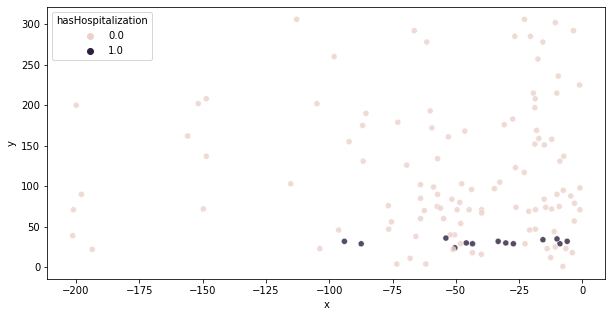

In [ ]:
#Graph for true label and distance from SVM border given date until hospitalization
plt.figure(figsize=(10,5))
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=0.8)

<AxesSubplot:xlabel='x', ylabel='y'>

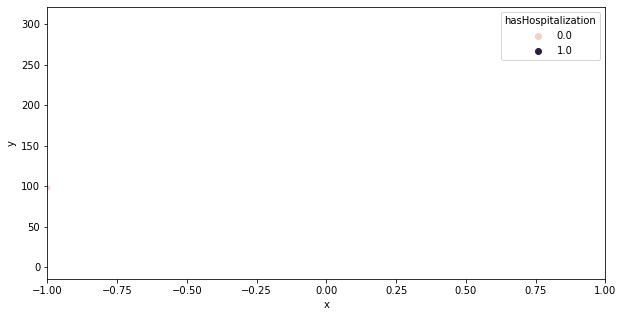

In [ ]:
#X-axis limited graph
plt.figure(figsize=(10,5))
plt.xlim(-1, 1)
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=1)